Backward Facing Step Flow (BFS) DEMO code

This notebook demonstrates solving steady-state Backward Facing Step Flow (BFS) using DeepFlow. The BFS flow is a common benchmark problem in fluid dynamics, where the flow separates and reattaches after encountering a step.

In [1]:
import deepflow as df
print("Deepflow is runned on:", df.device) # to change to cpu use df.device = 'cpu'
df.manual_seed(69) # for reproducibility

Deepflow is runned on: cuda


## 1. Define Geometry Domain
Set up the computational domain: a rectangle with a circular obstacle (cylinder). This defines the area for simulation.

In [2]:
rectangle = df.geometry.polygon([0,0.4], [0,1], [5, 1], [5,0], [1,0], [1,0.4])

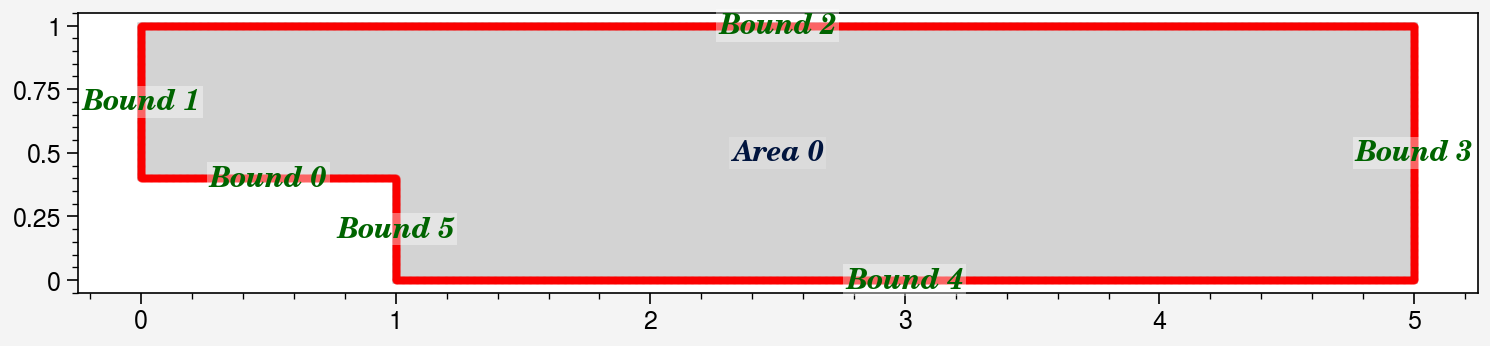

In [3]:
domain = df.domain(rectangle)
domain.show_setup()

## 2. Define Physics
Define the Navier-Stokes equations for fluid flow and apply boundary conditions (e.g., no-slip walls, inlet velocity).

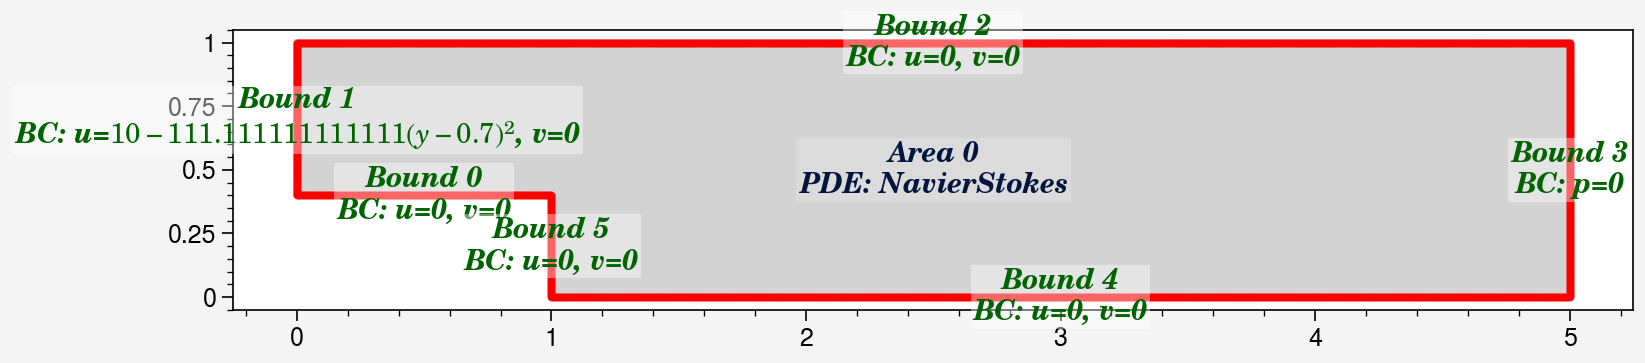

In [4]:
domain.bound_list[0].define_bc({'u': 0,'v': 0})
domain.bound_list[1].define_bc({'u': df.parabolic_func('y', 0.6, 1, 0.7),'v': 0})
domain.bound_list[2].define_bc({'u': 0,'v': 0})
domain.bound_list[3].define_bc({'p': 0})
domain.bound_list[4].define_bc({'u': 0,'v': 0})
domain.bound_list[5].define_bc({'u': 0,'v': 0})
domain.area_list[0].define_pde(df.NavierStokes(U=0.0001, L=1, mu=0.001, rho=1000))
domain.show_setup()


Sample initial points for training.

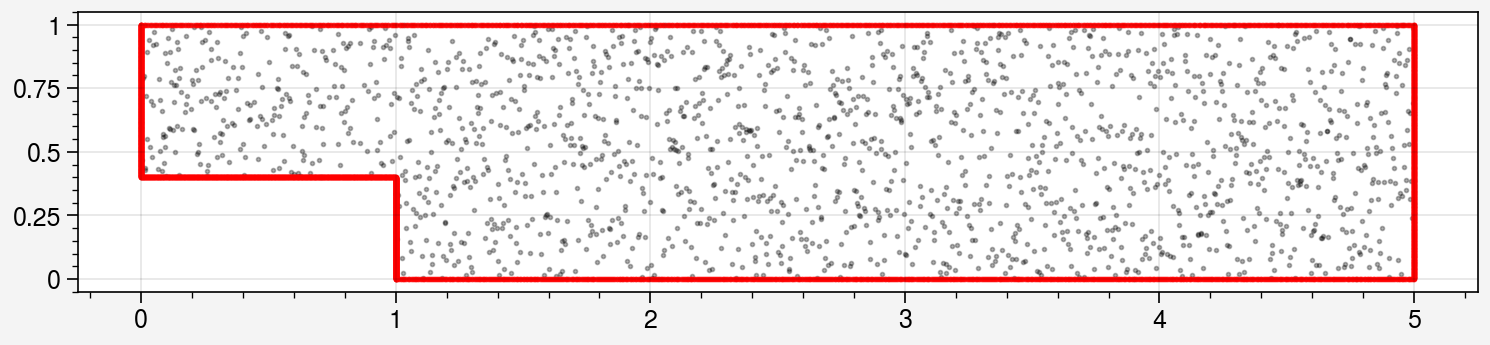

In [5]:
domain.sampling_lhs(bound_sampling_res=[1000, 1000, 1000, 1000, 1000, 1000], area_sampling_res=[2000])
domain.show_coordinates(display_physics=False)

## 3. Train the PINN model

Define how collocation points are sampled during training.

In [6]:
def do_in_adam(epoch, model):
    return
        
def do_in_lbfgs(epoch, model):
    return
    if epoch % 100 == 0 and epoch > 0:
        domain.sampling_R3(bound_sampling_res=[1000, 1000, 1000, 1000, 1], area_sampling_res=[2000])
        print(domain)

Train the model using Adam for initial training (faster convergence).

In [7]:
model0 = df.PINN(width=50, length=5, input_vars=['x','y'], output_vars=['u','v','p'])

# Train the model
model1, model1best = model0.train_adam(
    learning_rate=0.001,
    epochs=2000,
    calc_loss=df.calc_loss_simple(domain),
    threshold_loss=0.005,
    do_between_epochs=do_in_adam)

Epoch: 1, total_loss: 54.85159, bc_loss: 54.85147, pde_loss: 0.00012
Epoch: 200, total_loss: 16.55980, bc_loss: 14.83081, pde_loss: 1.72898
Epoch: 400, total_loss: 6.10844, bc_loss: 3.86418, pde_loss: 2.24426
Epoch: 600, total_loss: 2.69913, bc_loss: 1.27305, pde_loss: 1.42608
Epoch: 800, total_loss: 1.61956, bc_loss: 0.74461, pde_loss: 0.87495
Epoch: 1000, total_loss: 1.06095, bc_loss: 0.57254, pde_loss: 0.48841
Epoch: 1200, total_loss: 0.82440, bc_loss: 0.47019, pde_loss: 0.35421
Epoch: 1400, total_loss: 0.70941, bc_loss: 0.40436, pde_loss: 0.30506
Epoch: 1600, total_loss: 0.63107, bc_loss: 0.36355, pde_loss: 0.26752
Epoch: 1800, total_loss: 0.57608, bc_loss: 0.33324, pde_loss: 0.24283
Epoch: 2000, total_loss: 0.52760, bc_loss: 0.30945, pde_loss: 0.21815


Refine the model using LBFGS for higher precision.

In [8]:
# Train the model
model2 = model1best.train_lbfgs(
    calc_loss=df.calc_loss_simple(domain),
    epochs=350,
    threshold_loss=0.0001,
    do_between_epochs=do_in_lbfgs)

Epoch: 2001, total_loss: 0.51926, bc_loss: 0.30645, pde_loss: 0.21282
Epoch: 2051, total_loss: 0.11804, bc_loss: 0.07386, pde_loss: 0.04419
Epoch: 2101, total_loss: 0.02810, bc_loss: 0.01461, pde_loss: 0.01349
Epoch: 2151, total_loss: 0.01070, bc_loss: 0.00528, pde_loss: 0.00542
Epoch: 2201, total_loss: 0.00528, bc_loss: 0.00256, pde_loss: 0.00272
Epoch: 2251, total_loss: 0.00346, bc_loss: 0.00166, pde_loss: 0.00180
Epoch: 2301, total_loss: 0.00254, bc_loss: 0.00122, pde_loss: 0.00132


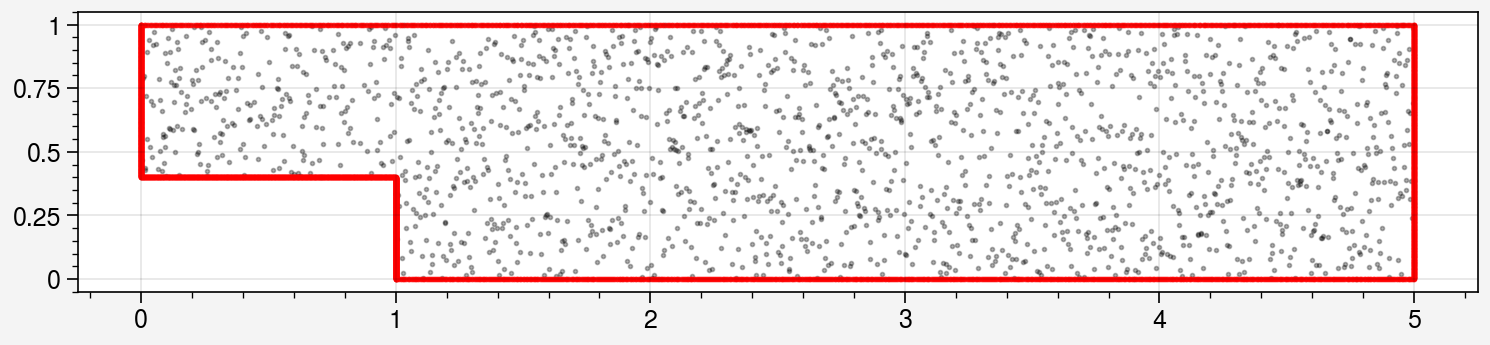

In [9]:
domain.show_coordinates()

Save or Load the model for later use

In [10]:
model2.save_as_pickle("model.pkl")
model2 = df.load_from_pickle("model.pkl")

## 4. Visualization

### 4.1 Visualize area

In [11]:
df.Visualizer.refwidth_default = 7

In [12]:
# Create object for evaluation
area_eval = domain.area_list[0].evaluate(model2)
# Sampling uniform points
area_eval.sampling_area([300, 60])
# Show available data's key
print(area_eval)

Available data keys: ('u', 'v', 'p', 'pde_residual', 'x', 'y', 'u_x', 'u_y', 'v_x', 'v_y', 'p_x', 'p_y', 'continuity_residual', 'x_momentum_residual', 'y_momentum_residual', 'total_loss', 'bc_loss', 'pde_loss')


In [13]:
area_eval['v_mag'] = (area_eval['u']**2 + area_eval['v']**2)**0.5

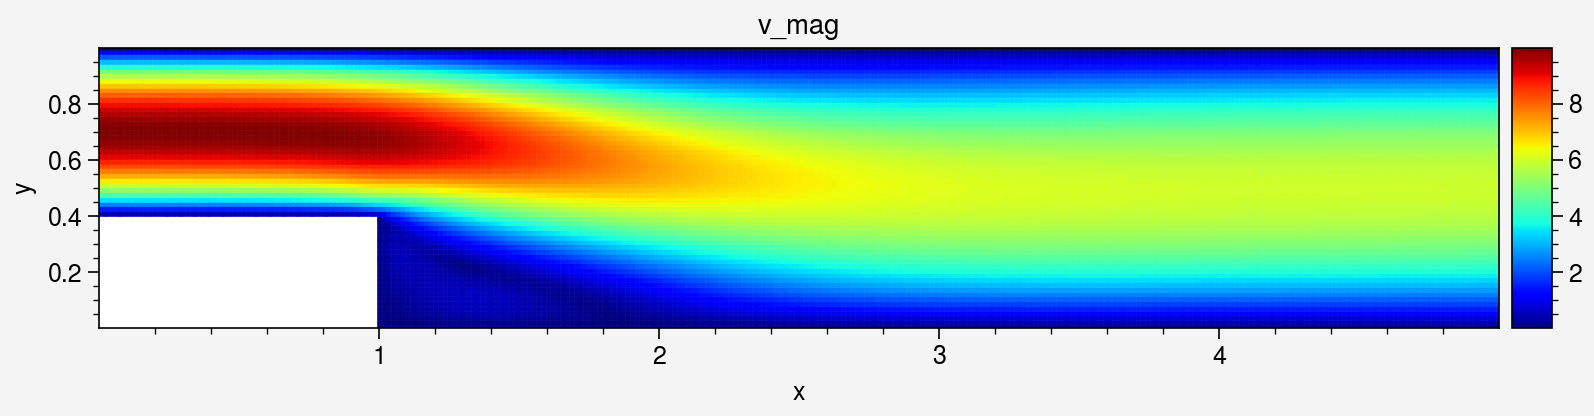

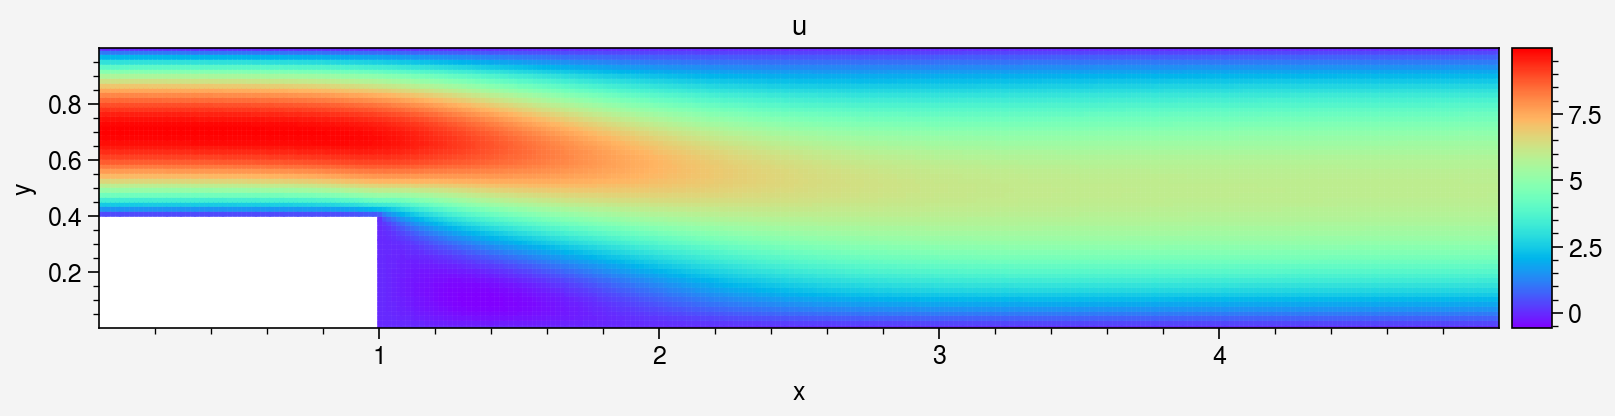

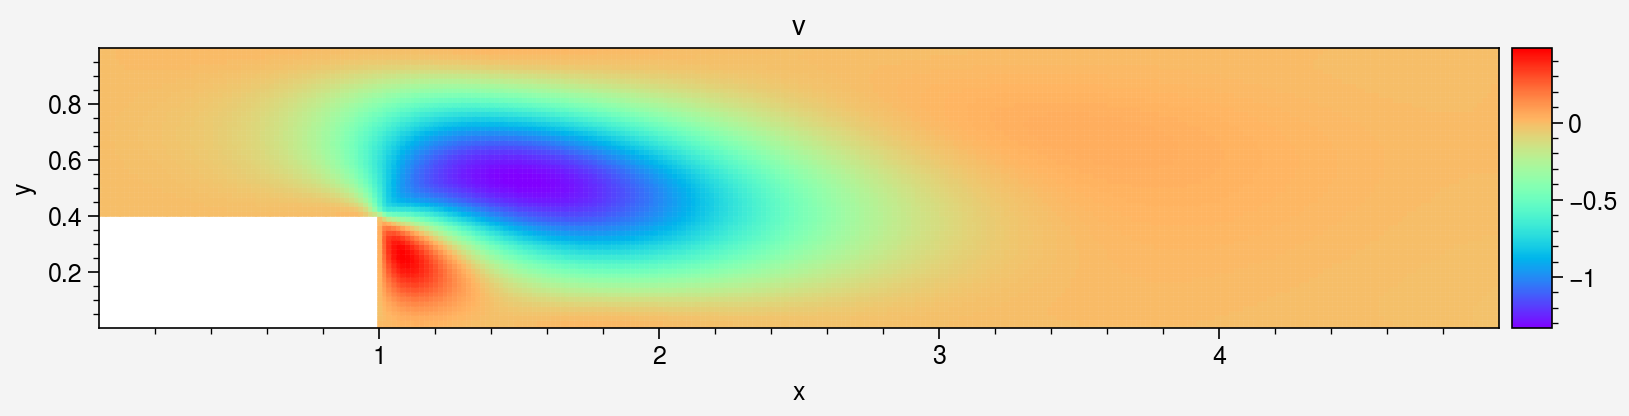

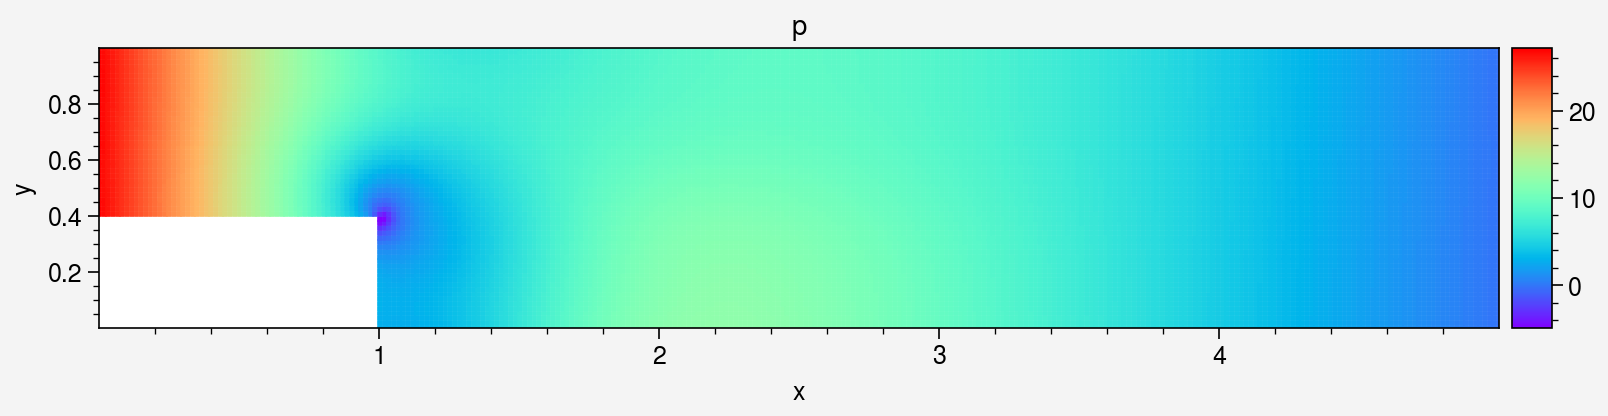

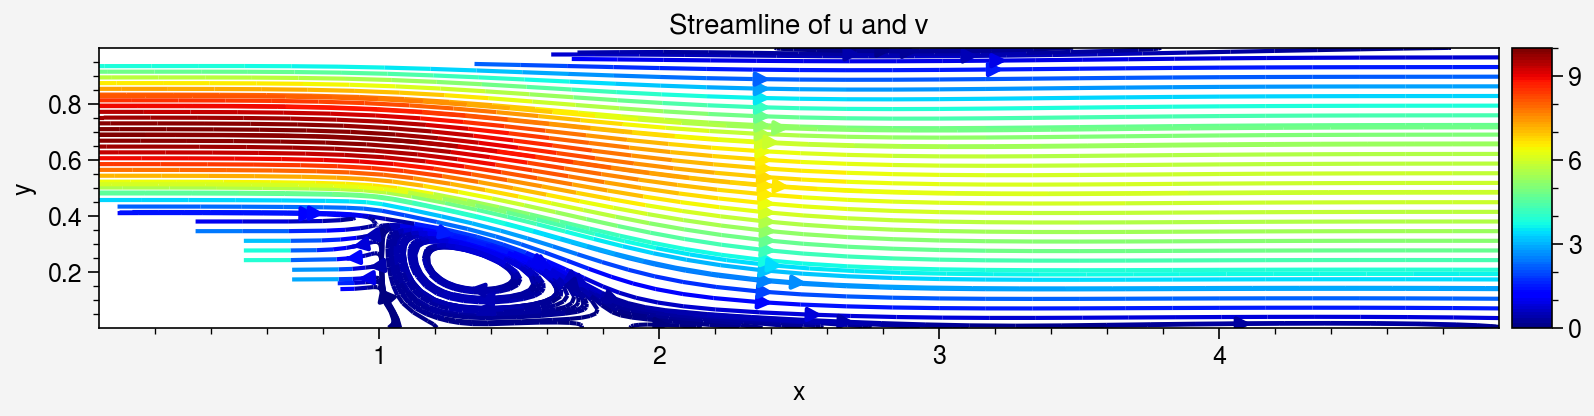

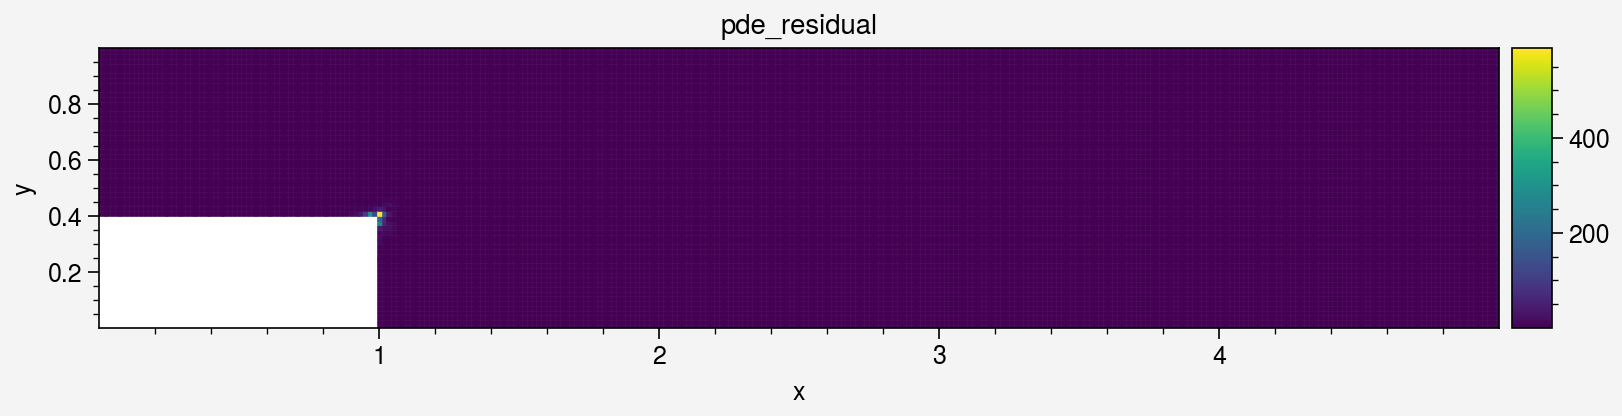

In [17]:
_ = area_eval.plot_color('v_mag', s=2, cmap='jet').savefig("colorplot_v_mag.png")
_ = area_eval.plot_color('u', s=2, cmap='rainbow')
_ = area_eval.plot_color('v', s=2, cmap='rainbow')
_ = area_eval.plot_color('p', s=2, cmap='rainbow')
_ = area_eval.plot_streamline('u', 'v', cmap = 'jet')
_ = area_eval.plot_color('pde_residual', s=2, cmap='viridis')

## 4.2 Visualize Neural Network data

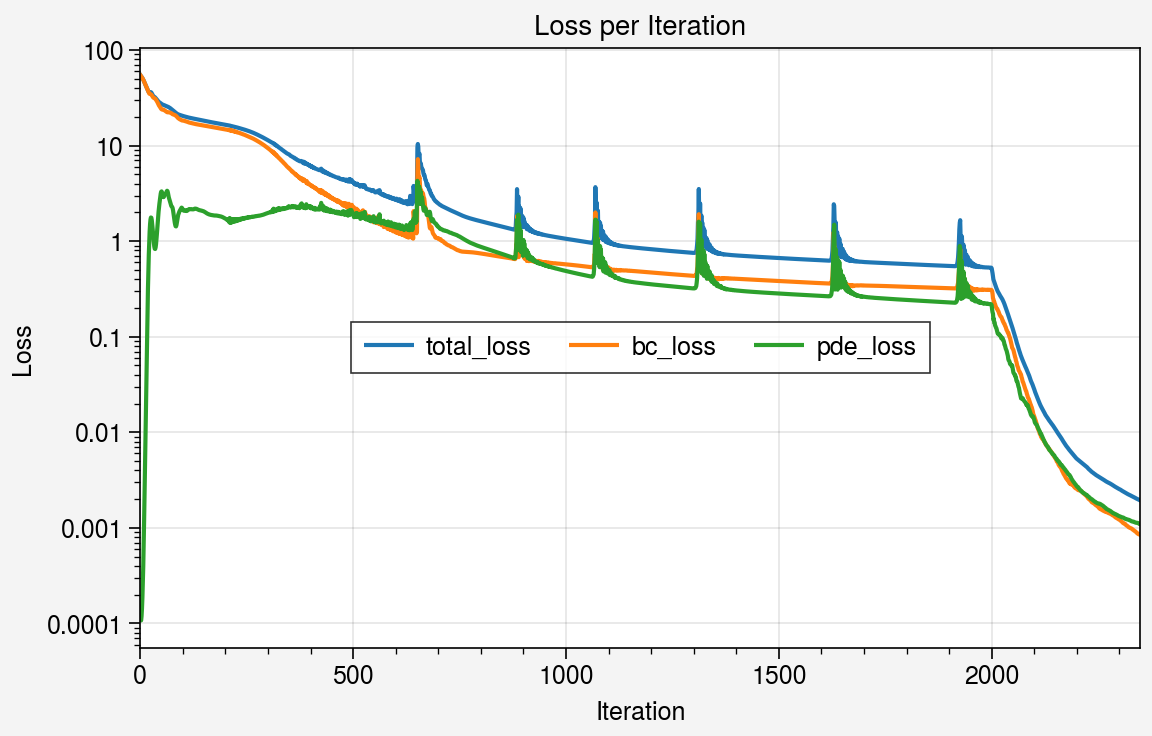

In [25]:
_ = area_eval.plot_loss_curve(log_scale=True)

### 4.4 Export data

In [16]:
# store the x,y,velocity_magnitude data
x_data = area_eval.data_dict['x']
y_data = area_eval.data_dict['y']
u_data = area_eval.data_dict['u']

#save as txt file
import numpy as np
array = np.column_stack((x_data, y_data, u_data))
np.savetxt('outlet_velocity.txt', array)